# Predict results of NBA games

The goal of this project is to be able to accurately predict future NBA games. 


## Hide/Unhide cells code

In [441]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


## Problems to solve throughout the project

- Defining target value - ther is no well-definded response variable and the predictors, like in classic Machine Learning problems.
- There is small number of observations - in NBA there are 30 teams, every team plays about 80 games per season
- In NBA rotation of players is huge. So building model, which is based on previous season results is questionable.
- Huge number of predictors.
- There will be many predictors correlated with each other.
- in one season the teams meet with each other maximum 4 times - there will be need to somehow estimate power for each team


## Dataset preparation

In [442]:
import pandas as pd
import numpy as np

### Import dataset

The data was gathered from the official site nba.stats.com with NBA statistics. The dataset consist
of 547 games from 2019-10-22 to 2020-01-06. The reason why we decide to choose only
historic games from one season is that the rotation of the players in the league between
seasons is huge. The consequence of that is that for example Golden State Warriors
team, which almost won the season 2018-2019, in season 2019-2020 is the worst team in
the NBA. So we don’t want to include information from previous seasons to prevent
their influcence on the future predictions.
Every row of our dataset stores information about teams, which played the game, the
result, game time in minutes and bunch of statistics for each team:


- PTS - points
- FGA - field goal attempts
- FGM - field goal made
- FG% - field goal accuracy
- 3PA - 3 point shoot attempts
- 3PM - 3 point shoot made
- 3P% - 3 point shoot accuracy
- FTA - free throw attempts
- FTM - free throw made
- FT% - free throw accuracy
- OREB - offensive rebounds
- DREB - defensive rebounds
- REB - total rebounds
- AST - assists
- STL - steals
- BLK - blocks
- TOV - turnovers
- "+/-"- plus-minus score

link to data: https://stats.nba.com/teams/boxscores/?sort=gdate&dir=1


In [443]:
data = pd.read_csv("nba_data_new", sep = ",")
#data = pd.read_csv("nba_updated.csv", sep = ",")
data['GAME DATE'] =pd.to_datetime(data['GAME DATE'])
data = data.sort_values(['GAME DATE'], ascending=True)
data.head()

,TEAM,MATCH UP,GAME DATE,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
1021,TOR,TOR vs. NOP,2019-10-22,W,265,130,42,103,40.8,14,...,84.2,16,41,57,23,7,3,17,24,8
474,LAC,LAC vs. LAL,2019-10-22,W,240,112,42,81,51.9,11,...,70.8,11,34,45,24,8,5,14,25,10
510,LAL,LAL @ LAC,2019-10-22,L,240,102,37,85,43.5,13,...,71.4,9,32,41,20,4,7,15,24,-10
693,NOP,NOP @ TOR,2019-10-22,L,265,122,43,102,42.2,19,...,85.0,16,37,53,30,4,9,19,34,-8
1093,WAS,WAS @ DAL,2019-10-23,L,240,100,37,93,39.8,11,...,83.3,11,36,47,26,6,3,17,32,-8


### Data restructurization

I restructurized the data to the nicer form. Now every match is one row and it store information about home and away team statistics. Also I change some variables names. Our target is the RESULT variable which belongs to one of two classes: H (home team won) or A (away team won).


In [444]:
import warnings
warnings.filterwarnings('ignore')



home = data[data['MATCH UP'].str.contains("vs")]
away = data[data['MATCH UP'].str.contains("@")]

home['MATCH UP'] = home['MATCH UP'].str.slice(8,11)
home = home.rename(columns = { 'MATCH UP' : 'TEAM_B'})
home = home.rename(columns = { 'TEAM' : 'TEAM_A'})

away['MATCH UP'] = away['MATCH UP'].str.slice(6,9)
away = away.rename(columns = { 'MATCH UP' : 'TEAM_A'})
away = away.rename(columns = { 'TEAM' : 'TEAM_B'})
away = away.drop(['W/L', 'MIN'],1)

nba_data = pd.merge(home, away, on = ['TEAM_A', 'TEAM_B', 'GAME DATE'], suffixes = ['_H', '_A'])
nba_data = nba_data.rename(columns = { 'TEAM_A' : 'HOME'})
nba_data = nba_data.rename(columns = { 'TEAM_B' : 'AWAY'})
nba_data['W/L'] = nba_data['W/L'].replace('W', 'H')
nba_data['W/L'] = nba_data['W/L'].replace('L', 'A')
nba_data = nba_data.rename(columns = { 'W/L' : 'RESULT'})

    
   
nba_data.head()
    


,HOME,AWAY,GAME DATE,RESULT,MIN,PTS_H,FGM_H,FGA_H,FG%_H,3PM_H,...,FT%_A,OREB_A,DREB_A,REB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,+/-_A
0,TOR,NOP,2019-10-22,H,265,130,42,103,40.8,14,...,85.0,16,37,53,30,4,9,19,34,-8
1,LAC,LAL,2019-10-22,H,240,112,42,81,51.9,11,...,71.4,9,32,41,20,4,7,15,24,-10
2,BKN,MIN,2019-10-23,A,265,126,48,101,47.5,15,...,78.6,12,40,52,23,9,4,13,22,1
3,CHA,CHI,2019-10-23,H,240,126,45,88,51.1,23,...,81.8,20,29,49,25,11,4,12,20,-1
4,DAL,WAS,2019-10-23,H,240,108,35,76,46.1,11,...,83.3,11,36,47,26,6,3,17,32,-8


## Data Exploration


In [445]:
import seaborn as sns
import matplotlib.pyplot as plt

First I check the basic statistic of the dataset. The number of mathes, number of features. The ration between games won at home and games won away. Just to give some perspective.

In [446]:
#what is the win rate for the home team?

# Total number of matches.
n_matches = nba_data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = nba_data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = np.sum(nba_data['RESULT'] == 'H')

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print(f"Total number of matches: {n_matches}")
print(f"Number of features: {n_features}")
print(f"Number of matches won by home team: {n_homewins}")
print(f"Win rate of home team: {win_rate}%")

Total number of matches: 547
Number of features: 42
Number of matches won by home team: 312
Win rate of home team: 57.038391224862885%


We can see that the chance of win the game is greater for home team.

### Creating new variable - ELO ranking


The main problem of predicting future games is that we can't predict the statistics of each team. We only know the teams and the location of the game. So it is very nice thing to be able to somehow estimate power of the team basing on previous games. The one way to do that is to make a team ranking, e.g. ELO ranking.

ELO ranking is the way to estimate power of a player or a team in various sports. Especially it is very popular in chess.
We have to define probability of win based on ELO ranking of two teams. Of course team with higher ELO has better chance to win the game.

$$p_{win}(ELO_1, ELO_2) = \frac{1}{1+10^{-\frac{ELO - ELO_2}{400}}}$$

For example, the probability that Magnus Carlsen, world champion in chess, wins againts best computer engine, AplhaZero, is:


In [447]:
def p_win(elo_rank_1, elo_rank_2):
    return 1/(1 + 10**(-(elo_rank_1-elo_rank_2)/400)  )

p_win(2872,3700)

0.008439548177234905

Next we have to be able to calculate the gain in ELO ranking for the team, which actually win the game. The formula for gain:

* if first team wins then gain in ELO ranking ($\Delta$) is equal to:
    $$\Delta = 20\times(1-p_{win}(ELO_1, ELO_2)$$
* if second team wins then gain in ELO ranking ($\Delta$) is equal to:
    $$\Delta = 20\times(1-p_{win}(ELO_2, ELO_1)$$
    
I calculated ELO rating for each team. I started from starting ELO ranking equals
1500 for each team. Then I analyzed all games from the begginning of the season and
obtained final ELO ranking for every team. To give some perspective the Milwaukee
Bucks (MIL) had the highest ELO equals to 1810 and Golden State Warriors had 1611.
In the middle was Orlando Magic (ORL) with 1709 points. The whole rating is presented below.


In [448]:
teams = nba_data["HOME"].unique()
n_teams = np.shape(teams)[0]

elo_start = 1500
elo = dict(zip(teams, np.repeat(elo_start, n_teams)))

for index, row in nba_data.iterrows():
    home = row['HOME']
    away = row['AWAY']
    
    home_elo = elo[home]
    away_elo = elo[away]
    
    if row['RESULT'] == 'H':
        elo[home] += 20*(1-p_win(home_elo, away_elo))
    else:
        elo[away] += 20*(1-p_win(away_elo, home_elo))
 
{k: v for k, v in sorted(elo.items(), key=lambda item: item[1], reverse=True)}

# for k,v in elo.items():
#     print(v)

{'MIL': 1764.4499619715216,
 'LAL': 1747.661457086966,
 'MIA': 1737.7429740483572,
 'LAC': 1732.7285813729004,
 'DEN': 1726.7102632003282,
 'BOS': 1723.853692645112,
 'HOU': 1723.3514842697793,
 'PHI': 1720.772714035593,
 'UTA': 1719.1160768117666,
 'TOR': 1717.5690219802163,
 'IND': 1715.646058224364,
 'DAL': 1713.8668085887036,
 'OKC': 1699.1676655609328,
 'ORL': 1670.4494844144494,
 'MEM': 1660.6929374816366,
 'SAS': 1656.732812416082,
 'BKN': 1655.4399133470129,
 'CHA': 1649.2236922326736,
 'POR': 1646.0147563886337,
 'SAC': 1645.5158261601257,
 'PHX': 1638.8341831868422,
 'MIN': 1637.6824278190675,
 'WAS': 1635.88548038789,
 'NOP': 1634.7703011520343,
 'CHI': 1630.9820946636564,
 'DET': 1630.677244845093,
 'NYK': 1608.464243371559,
 'CLE': 1603.9533402442962,
 'GSW': 1598.8747084247,
 'ATL': 1588.753969151456}

I checked obtained results with the power ranking on nba.stats and it is very accurate.


## Finding important predictors

In this section I used my dataset to extract important features.


In [449]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.discrete.discrete_model as sm

### All features

- PTS - points
- FGA - field goal attempts
- FGM - field goal made
- FG% - field goal accuracy
- 3PA - 3 point shoot attempts
- 3PM - 3 point shoot made
- 3P% - 3 point shoot accuracy
- FTA - free throw attempts
- FTM - free throw made
- FT% - free throw accuracy
- OREB - offensive rebounds
- DREB - defensive rebounds
- REB - total rebounds
- AST - assists
- STL - steals
- BLK - blocks
- TOV - turnovers
- "+/-"- plus-minus score


In [450]:
#nba_data['ELO_H'] = nba_data['HOME'].map(elo)
#nba_data['ELO_A'] = nba_data['AWAY'].map(elo)
# nba_data.head()

# np.array(nba_data['AWAY'] == 'TOR')
# a = nba_data[['GAME DATE', 'PTS_H']][np.array(nba_data['HOME'] == 'SAS') & np.array(nba_data['MIN'] == 240)]
# b = nba_data[['GAME DATE', 'PTS_A']][np.array(nba_data['AWAY'] == 'SAS') & np.array(nba_data['MIN'] == 240)]
# #plt.plot(a, 'bo')
# #plt.plot(b, 'ro')
# #plt.plot(b, marker="o"

# a = a.rename(columns={"PTS_H" : 'PTS'})
# b=b.rename(columns={"PTS_A" : "PTS"})

# c = list(a.append(b).sort_values(by='GAME DATE')['PTS'])

# #plt.plot(c, 'bo')
# np.array(c)


# nba_def = pd.read_csv("nba_def_20.csv", sep = ",")
# nba_def = nba_def[['Team', 'DRtg']]
# nba_def = nba_def.rename(columns={'DRtg' : 'DRTG'})


# nba_def['DRTG'].values

# nba_def = nba_data.merge( nba_def, left_on='HOME', right_on = 'Team').merge(nba_def, left_on='AWAY', right_on = 'Team', suffixes=('_H', '_A'))

# nba_def = nba_def.drop(['Team_H', 'Team_A'], axis=1)

# nba_def['POW_H'] = nba_def['PTS_H']/nba_def['DRTG_A']
# nba_def['POW_A'] = nba_def['PTS_A']/nba_def['DRTG_H']




# a = nba_def[['GAME DATE', 'POW_H']][np.array(nba_def['HOME'] == 'LAC') & np.array(nba_def['MIN'] == 240)]
# b = nba_def[['GAME DATE', 'POW_A']][np.array(nba_def['AWAY'] == 'LAC') & np.array(nba_def['MIN'] == 240)]


# a = a.rename(columns={"POW_H" : 'POW'})
# b=b.rename(columns={"POW_A" : "POW"})

# c = list(a.append(b).sort_values(by='GAME DATE')['POW'])

# plt.plot(c, 'bo')
# np.array(c)

# nba_def

#nba_data[np.array(nba_data['HOME'] == 'HOU') | np.array(nba_data['AWAY'] == 'HOU')]

In [451]:


# nba_def['ELO_H'] = nba_def['HOME'].map(elo)
# nba_def['ELO_A'] = nba_def['AWAY'].map(elo)
# #data_final = data_final.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')
# nba_def.head()

# nba_def.to_csv("nba_dataset.csv")

### Basic feature selection

I plotted the correlation matrix. I took absolute value of the correlations to capture some dependencies. 


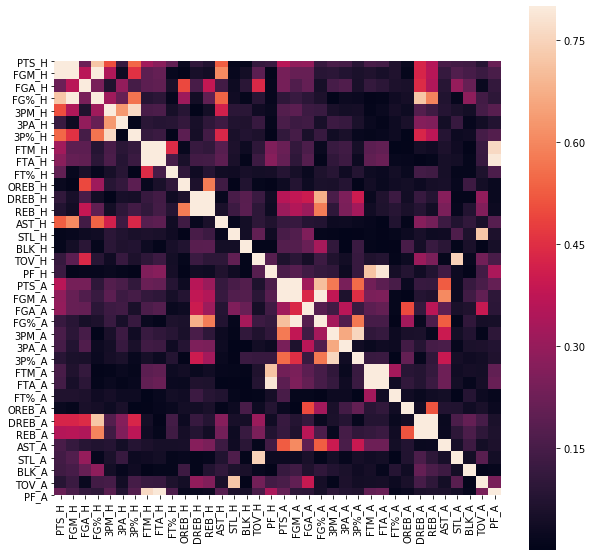

In [452]:
features = list(nba_data.drop(['HOME', 'AWAY', 'GAME DATE', 'RESULT'], axis=1).columns)

# doesn't make sens
features.remove('MIN')

features.remove('+/-_H')
features.remove('+/-_A')

corrmat = np.abs(nba_data[features].corr())
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, vmax=.8, square=True)


columns = [ 'FGA_H', 'PTS_H', '3PA_H', 'FTA_H', 'REB_H', 'STL_H', 'BLK_H', 'TOV_H', 'PF_H']

In the first step I removed the predictors which were strongly correlated. For example three point percentage is equal to the ratio of 3-point shot made and 3-point shots attempt:

$$3P\% = \frac{3PM}{3PA} $$

So I had to remove at least one of them. After basic feature selection I plotted again the correlation matrix.

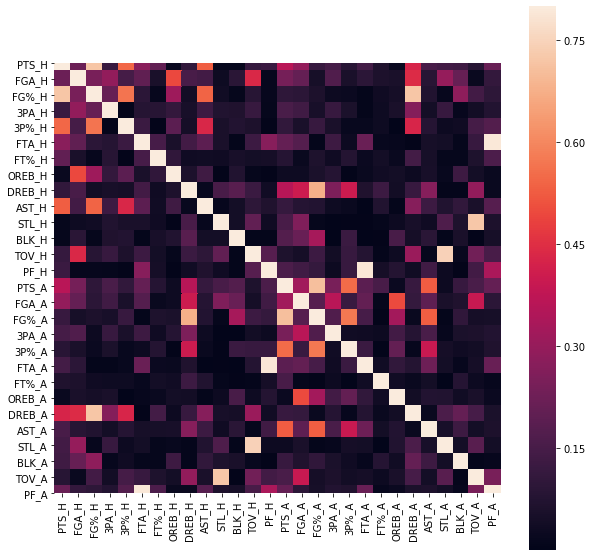

In [453]:
features = list(nba_data.drop(['HOME', 'AWAY', 'GAME DATE', 'RESULT'], axis=1).columns)

# doesn't make sens
features.remove('MIN')

features.remove('+/-_H')
features.remove('+/-_A')

features.remove('FGM_H')
features.remove('FGM_A')

features.remove('3PM_H')
features.remove('3PM_A')

features.remove('FTM_H')
features.remove('FTM_A')

features.remove('REB_H')
features.remove('REB_A')


corrmat = np.abs(nba_data[features].corr())
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, vmax=.8, square=True)

### Feature selection based on variance importance and t-tests from logistic regression model

The idea behind second step of feature selection is to build a Random Forest model and Logistic Regression model. Then use a variance importance and p-values of t-test to choose important predictors.


In [454]:
from sklearn import linear_model
import numpy as np
import scipy.stats as stat

X_train, X_test, y_train, y_test = train_test_split(nba_data[features].values , nba_data['RESULT'].values, test_size = 0.3,random_state=42)

class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = np.round(p_values,6)
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

Foreach predictor I printed variance importance and p-values.

In [455]:
clf_RF = RandomForestClassifier()
clf_RF.fit(X_train, y_train)

clf_LR = LogisticReg(max_iter=1000)
clf_LR.fit(X_train, y_train)

df_importance = pd.DataFrame(zip(features,clf_RF.feature_importances_, clf_LR.p_values), columns=['Var','Variable Importance','p_value'])
df_importance.sort_values(['Variable Importance'], ascending=False)

,Var,Variable Importance,p_value
14,PTS_A,0.148190,0.102607
0,PTS_H,0.141887,0.058471
2,FG%_H,0.096312,0.845895
16,FG%_A,0.093512,0.784286
22,DREB_A,0.054223,0.687326
18,3P%_A,0.050609,0.731297
8,DREB_H,0.046207,0.820754
4,3P%_H,0.036772,0.856770
23,AST_A,0.027506,0.803901
5,FTA_H,0.024591,0.993967


Then I removed unrelevant variables. I did it one-by-one to avoid removal of important variables. The features I selected are presented below:

In [456]:
final_features = features.copy()


final_features.remove('OREB_A')
final_features.remove('OREB_H')

final_features.remove('TOV_A')
final_features.remove('TOV_H')

final_features.remove('STL_A')
final_features.remove('STL_H')

final_features.remove('FT%_A')
final_features.remove('FT%_H')

final_features.remove('FTA_A')
final_features.remove('FTA_H')

final_features.remove('AST_A')

final_features.remove('DREB_H')

final_features.remove('BLK_A')

final_features.remove('PF_H')
final_features.remove('PF_A')

final_features.remove('FGA_A')

final_features.remove('BLK_H')

final_features.remove('3P%_A')
final_features.remove('3P%_H')

final_features.remove('FG%_H')
final_features.remove('FG%_A')

final_features.remove('AST_H')

final_features.remove('DREB_A')
final_features.remove('PTS_A')


X_train, X_test, y_train, y_test = train_test_split(nba_data[final_features].values , nba_data['RESULT'].values, test_size = 0.3,random_state=42)

clf_RF = RandomForestClassifier()
clf_RF.fit(X_train, y_train)
clf_RF.score(X_test, y_test)

clf_LR = LogisticReg(max_iter=1000)
clf_LR.fit(X_train, y_train)


df_importance = pd.DataFrame(zip(final_features,clf_RF.feature_importances_, clf_LR.p_values), columns=['Var','Variable Importance','p_value'])
df_importance.sort_values(['p_value'], ascending=False)

,Var,Variable Importance,p_value
1,FGA_H,0.191693,0.016677
2,3PA_H,0.196467,0.013978
3,3PA_A,0.203542,0.000200
0,PTS_H,0.408298,0.000000


I selected only 4 final variables and plotted a correlation matrix of them to check dependencies.

In [457]:
#corrmat = nba_data[final_features].corr()
#f, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(corrmat, vmax=.8, cbar=True, square=True, annot=True)

rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = nba_data[final_features].corr()
corr.style.background_gradient(cmap='coolwarm')

,PTS_H,FGA_H,3PA_H,3PA_A
PTS_H,1,0.21949,0.119353,0.145154
FGA_H,0.21949,1,0.291001,0.168568
3PA_H,0.119353,0.291001,1,0.116276
3PA_A,0.145154,0.168568,0.116276,1


On the plot I plotted the pairplot with predictors. One can notice that none of them is a strong predictor.

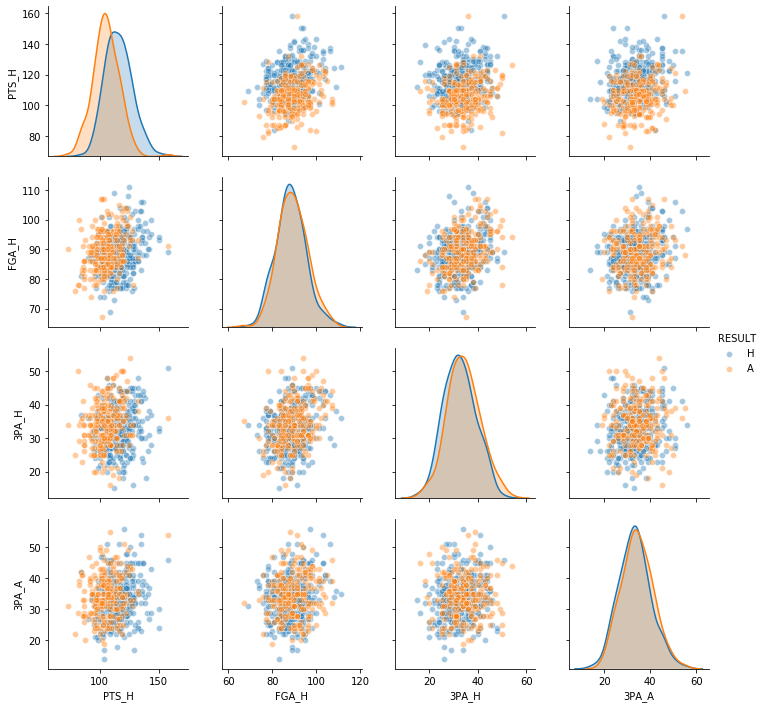

In [458]:
f = final_features.copy()
f.append('RESULT')
sns.pairplot(nba_data[f], hue="RESULT", plot_kws={'alpha': 0.4})

## Models

### Training dataset

In [459]:
#final_features

In [460]:
columns = [ 'FGA_H', 'PTS_H', '3PA_H', 'FTA_H', 'REB_H', 'STL_H', 'BLK_H', 'TOV_H', 'PF_H']
columns = final_features.copy()

#features = [col[:-2] for col in columns]
#features.insert(0,'HOME')
#new_cols = columns
#new_cols.insert(0,'HOME')
d = nba_data.groupby(by=['HOME']).median()[columns]
d.columns = columns

features_home = []
features_away = []
for col in columns:
    if col.endswith('H') == True:
        features_home.append(col)
    else:
        features_away.append(col)
#print(features_home,features_away)
#d.sort_values(by=list(imp.sort_values([1], ascending=False)[0]))

In [461]:
data_final = nba_data[['HOME', 'AWAY', 'RESULT']]
data_final['ELO_H'] = data_final['HOME'].map(elo)
data_final['ELO_A'] = data_final['AWAY'].map(elo)
data_final = data_final.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')
#data_final.head()

I created the training dataset basing on selected features. The response variable is "RESULT", which carry information who wins. The predictors are medians of relevant statistics, calculated separatly for each team. They represent team performance throught the season.

In [462]:
dataset = data_final.drop(['HOME', 'AWAY'], axis=1)
data_final.head(10)

,HOME,AWAY,RESULT,ELO_H,ELO_A,PTS_H,FGA_H,3PA_H,3PA_A
0,TOR,NOP,H,1717.569022,1634.770301,113.0,88.0,36.0,34.5
1,LAC,NOP,H,1732.728581,1634.770301,115.5,92.0,32.5,34.5
2,BKN,NOP,H,1655.439913,1634.770301,108.5,89.0,34.5,34.5
3,CHA,NOP,A,1649.223692,1634.770301,107.0,86.0,31.0,34.5
4,DAL,NOP,H,1713.866809,1634.770301,117.0,89.0,39.0,34.5
5,MIA,NOP,H,1737.742974,1634.770301,117.0,83.5,32.5,34.5
6,UTA,NOP,H,1719.116077,1634.770301,109.5,83.5,31.5,34.5
7,POR,NOP,A,1646.014756,1634.770301,115.0,91.0,34.0,34.5
8,PHI,NOP,H,1720.772714,1634.770301,113.0,89.0,29.0,34.5
9,PHX,NOP,A,1638.834183,1634.770301,117.0,90.5,35.0,34.5


I split the data into train and test dataset. The test dataset is 20% of the whole data. 

In [463]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(['RESULT'],axis=1).values , dataset['RESULT'].values, test_size = 0.1)

### Logistic Regression

Logistic regression is a statistical method for analyzing a dataset in which there are one
or more independent variables that determine an outcome. The outcome is measured
with a dichotomous variable (in which there are only two possible outcomes).
In logistic regression, the dependent variable is binary or dichotomous, i.e. it only contains
data coded as 1 (TRUE, success, pregnant, etc.) or 0 (FALSE, failure, non-pregnant,
etc.). In our case the response variable is "H" (home team win) or "A" (away team win).
The goal of logistic regression is to find the best fitting (yet biologically reasonable)
model to describe the relationship between the dichotomous characteristic of interest
(response or outcome variable) and a set of independent (predictor or explanatory)
variables. Logistic regression generates the coefficients (and its standard errors and
significance levels) of a formula to predict a logit transformation of the probability of
presence of the characteristic of interest.


In [464]:
clf_LR = LogisticRegression(max_iter=100000)
clf_LR.fit(X_train, y_train)
print(f"Logistic regression test score: {clf_LR.score(X_test, y_test)}")

Logistic regression test score: 0.6363636363636364


### Random Forest


In the **bagging** model, trees are built based on bootstrap samples. The main advantage of this approach is based on the reduction of variance and the assumption of independence. However, note that bootstrap samples depend on each other because they come from the same dataset. As a result, the trees created on this basis are also dependent (similar). The introduction of additional randomness in building trees in random forests allows to reduce this relationship.
Trees in **random forests** (similar to **bagging**) are built on the basis of boostrap samples. However, in the case of forests, $ m $ randomly selected predictors , which we can use for splitting. The introduction of additional randomness in building subsequent trees significantly improves the capabilities of the model.


In [465]:
clf_RF = RandomForestClassifier()
clf_RF.fit(X_train, y_train)

print(f"Random Forest test score: {clf_RF.score(X_test, y_test)}")

Random Forest test score: 0.5454545454545454


### Gradient Boosting

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

In [466]:
clf_GB = GradientBoostingClassifier()
clf_GB.fit(X_train, y_train)
print(f"Gradient Boosting test score: {clf_GB.score(X_test, y_test)}")

Gradient Boosting test score: 0.5818181818181818


### K Nearest Neighbours


One of the most basic machine learning methods is the $ k $ method of the nearest neighbors. The classification of the data point from the test set is based on the "vote" by $ k $ nearest neighbors. The proximity of the neighborhood is most often calculated in relation to the Euclidean metric.

In [467]:
clf_KNN = KNeighborsClassifier(50)
clf_KNN.fit(X_train, y_train)
print(f"KNN test score: {clf_KNN.score(X_test, y_test)}")

KNN test score: 0.6


### Support Vectors Machines

In machine learning, support-vector machines (SVMs) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier (although methods such as Platt scaling exist to use SVM in a probabilistic classification setting). An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on the side of the gap on which they fall.

In [468]:
clf_SVM = LinearSVC(max_iter=1000000)
clf_SVM.fit(X_train, y_train)
print(f"SVM test score: {clf_SVM.score(X_test, y_test)}")

SVM test score: 0.509090909090909


### Tuning parametres for XGBoosting Classifier

I also builded a XGBoost model with hiperparametres tuning. The XGboost classifier is a numerically optimized GRadient Boosting Classifier. Below one can see training and tests scores after choosing the best model.

In [469]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import xgboost as xgb
from sklearn.metrics import f1_score

# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf_XGB = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='H')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf_XGB,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf_XGB = grid_obj.best_estimator_


def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    y_pred = clf.predict(features)
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))



# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf_XGB, X_train, y_train)
print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf_XGB, X_test, y_test)
print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

F1 score and accuracy score for training set: 0.7971 , 0.7724.
F1 score and accuracy score for test set: 0.6875 , 0.6364.


## Prediction of real game results

Starting form 7/01/2020 each day I predicted a real games results and noted the actual results. In the final section I gathered together all scores and printed accuracy for each model.


### 7/01/2020

In [470]:
home = ['CLE', 'TOR', 'BKN', 'MEM', 'PHX', 'LAL']
away = ['DET', 'POR', 'OKC', 'MIN', 'SAC', 'NYK']
predictions = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'] )


predictions['Actual Result'] = ['A', 'A', 'A', 'H', 'A', 'H']

match = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'])
match['ELO_H'] = match['HOME'].map(elo)
match['ELO_A'] = match['AWAY'].map(elo)
pred=match.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')
predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)


In [471]:
predictions['KNN'] = clf_KNN.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['RF_prob'] = np.round(np.max(clf_RF.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Gradient Boosting'] = clf_GB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['GB_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions['XGradient Boosting'] = clf_XGB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['XGB_prob'] = np.round(np.max(clf_XGB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Logistic Regression'] = clf_LR.predict(pred.drop(['HOME', 'AWAY'],axis=1).values )
predictions['LR_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


In [472]:
predictions_final = predictions.copy()
predictions

,HOME,AWAY,Actual Result,Random Forest,KNN,RF_prob,Gradient Boosting,GB_prob,XGradient Boosting,XGB_prob,Logistic Regression,LR_prob
0,CLE,DET,A,A,A,0.78,H,0.51,A,0.51,A,0.51
1,TOR,POR,A,H,H,0.92,H,0.83,H,0.85,H,0.83
2,BKN,OKC,A,H,A,0.52,A,0.58,A,0.58,A,0.58
3,MEM,MIN,H,H,A,0.85,H,0.55,H,0.54,H,0.55
4,PHX,SAC,A,H,A,0.84,A,0.55,A,0.53,H,0.55
5,LAL,NYK,H,H,H,1.00,H,0.96,H,0.90,H,0.96


In [473]:
n = np.shape(predictions)[0]

print(f"Random Forest score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Random Forest']])[0] / n *100,2)} %")
print(f"KNN score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['KNN']])[0] / n *100,2)} %")
print(f"Gradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Gradient Boosting']])[0] / n *100,2)} %")
print(f"XGradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['XGradient Boosting']])[0] / n *100,2)} %")
print(f"Logistic Regression score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Logistic Regression']])[0] / n *100,2)} %")


Random Forest score: 50.0 %
KNN score: 66.67 %
Gradient Boosting score: 66.67 %
XGradient Boosting score: 83.33 %
Logistic Regression score: 66.67 %


### 8/1/2020

In [474]:
home = ['CHA', 'IND', 'BOS', 'ORL', 'DAL', 'ATL','NOP', 'UTA', 'GSW']
away = ['TOR', 'MIA', 'SAS', 'WAS', 'DEN', 'HOU', 'CHI', 'NYK', 'MIL']

predictions = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'] )
predictions['Actual Result'] = ['A', 'A', 'A', 'H', 'A', 'A', 'H', 'H', 'A']

match = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'])
match['ELO_H'] = match['HOME'].map(elo)
match['ELO_A'] = match['AWAY'].map(elo)
pred=match.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

In [475]:
predictions['KNN'] = clf_KNN.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['RF_prob'] = np.round(np.max(clf_RF.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Gradient Boosting'] = clf_GB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['GB_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions['XGradient Boosting'] = clf_XGB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['XGB_prob'] = np.round(np.max(clf_XGB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Logistic Regression'] = clf_LR.predict(pred.drop(['HOME', 'AWAY'],axis=1).values )
predictions['LR_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


In [476]:
predictions_final = pd.concat([predictions_final, predictions])
predictions

,HOME,AWAY,Actual Result,Random Forest,KNN,RF_prob,Gradient Boosting,GB_prob,XGradient Boosting,XGB_prob,Logistic Regression,LR_prob
0,CHA,TOR,A,A,A,0.94,A,0.95,A,0.88,A,0.95
1,IND,MIA,A,H,H,0.58,H,0.60,H,0.56,H,0.60
2,BOS,SAS,A,H,H,0.97,H,0.97,H,0.92,H,0.97
3,ORL,WAS,H,H,H,0.87,H,0.84,H,0.79,H,0.84
4,DAL,DEN,A,A,H,0.63,A,0.62,A,0.60,H,0.62
5,ATL,HOU,A,A,A,0.87,A,0.85,A,0.82,A,0.85
6,NOP,CHI,H,A,A,0.92,A,0.87,A,0.57,A,0.87
7,UTA,NYK,H,H,H,0.84,H,0.92,H,0.88,H,0.92
8,GSW,MIL,A,A,A,0.75,A,0.98,A,0.90,A,0.98


In [477]:
n = np.shape(predictions)[0]

print(f"Random Forest score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Random Forest']])[0] / n *100,2)} %")
print(f"KNN score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['KNN']])[0] / n *100,2)} %")
print(f"Gradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Gradient Boosting']])[0] / n *100,2)} %")
print(f"XGradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['XGradient Boosting']])[0] / n *100,2)} %")
print(f"Logistic Regression score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Logistic Regression']])[0] / n *100,2)} %")


Random Forest score: 66.67 %
KNN score: 55.56 %
Gradient Boosting score: 66.67 %
XGradient Boosting score: 66.67 %
Logistic Regression score: 55.56 %


### 9/1/2020


In [478]:
home = ['PHI', 'DET', 'MIN', 'OKC']
away = ['BOS', 'CLE', 'POR', 'HOU']

predictions = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'] )
predictions['Actual Result'] = ['H', 'A', 'H', 'H']

match = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'])
match['ELO_H'] = match['HOME'].map(elo)
match['ELO_A'] = match['AWAY'].map(elo)
pred=match.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')



In [479]:
predictions['KNN'] = clf_KNN.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['RF_prob'] = np.round(np.max(clf_RF.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Gradient Boosting'] = clf_GB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['GB_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions['XGradient Boosting'] = clf_XGB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['XGB_prob'] = np.round(np.max(clf_XGB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Logistic Regression'] = clf_LR.predict(pred.drop(['HOME', 'AWAY'],axis=1).values )
predictions['LR_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


In [480]:
predictions_final = pd.concat([predictions_final, predictions])
predictions

,HOME,AWAY,Actual Result,KNN,Random Forest,RF_prob,Gradient Boosting,GB_prob,XGradient Boosting,XGB_prob,Logistic Regression,LR_prob
0,PHI,BOS,H,H,H,0.91,H,0.88,H,0.78,H,0.88
1,DET,CLE,A,H,H,0.61,A,0.61,H,0.59,H,0.61
2,MIN,POR,H,A,A,0.62,A,0.70,A,0.67,A,0.70
3,OKC,HOU,H,H,A,0.62,A,0.59,A,0.57,H,0.59


In [481]:
n = np.shape(predictions)[0]

print(f"Random Forest score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Random Forest']])[0] / n *100,2)} %")
print(f"KNN score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['KNN']])[0] / n *100,2)} %")
print(f"Gradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Gradient Boosting']])[0] / n *100,2)} %")
print(f"XGradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['XGradient Boosting']])[0] / n *100,2)} %")
print(f"Logistic Regression score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Logistic Regression']])[0] / n *100,2)} %")



Random Forest score: 25.0 %
KNN score: 50.0 %
Gradient Boosting score: 50.0 %
XGradient Boosting score: 25.0 %
Logistic Regression score: 50.0 %


### 10/1/2020

In [482]:
home = ['WAS', 'NYK', 'BKN', 'MEM', 'CHI', 'PHI', 'UTA', 'DAL', 'SAC', 'LAC']
away = ['ATL', 'NOP', 'MIA', 'SAS', 'IND', 'ORL', 'CHA', 'LAL', 'MIL', 'GSW']

predictions = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'] )
predictions['Actual Result'] = ['H', 'A', 'H', 'H', 'A', 'H', 'H', 'A','A', 'H']

match = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'])
match['ELO_H'] = match['HOME'].map(elo)
match['ELO_A'] = match['AWAY'].map(elo)
pred=match.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')

In [483]:
predictions['KNN'] = clf_KNN.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['RF_prob'] = np.round(np.max(clf_RF.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Gradient Boosting'] = clf_GB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['GB_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions['XGradient Boosting'] = clf_XGB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['XGB_prob'] = np.round(np.max(clf_XGB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Logistic Regression'] = clf_LR.predict(pred.drop(['HOME', 'AWAY'],axis=1).values )
predictions['LR_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions_final = pd.concat([predictions_final, predictions])
predictions

,HOME,AWAY,Actual Result,KNN,Random Forest,RF_prob,Gradient Boosting,GB_prob,XGradient Boosting,XGB_prob,Logistic Regression,LR_prob
0,WAS,ATL,H,H,H,0.66,H,0.79,H,0.68,H,0.79
1,NYK,NOP,A,A,A,0.61,A,0.65,A,0.65,A,0.65
2,BKN,MIA,H,A,A,0.71,A,0.57,A,0.62,A,0.57
3,MEM,SAS,H,A,A,0.67,H,0.55,H,0.55,H,0.55
4,CHI,IND,A,A,A,0.68,A,0.79,A,0.75,A,0.79
5,PHI,ORL,H,H,H,0.89,H,0.95,H,0.89,H,0.95
6,UTA,CHA,H,H,H,0.92,H,0.89,H,0.87,H,0.89
7,DAL,LAL,A,H,A,1.00,A,0.96,A,0.81,A,0.96
8,SAC,MIL,A,A,A,0.91,A,0.95,A,0.89,A,0.95
9,LAC,GSW,H,H,H,0.97,H,0.96,H,0.91,H,0.96


In [484]:
n = np.shape(predictions)[0]

print(f"Random Forest score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Random Forest']])[0] / n *100,2)} %")
print(f"KNN score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['KNN']])[0] / n *100,2)} %")
print(f"Gradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Gradient Boosting']])[0] / n *100,2)} %")
print(f"XGradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['XGradient Boosting']])[0] / n *100,2)} %")
print(f"Logistic Regression score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Logistic Regression']])[0] / n *100,2)} %")


Random Forest score: 80.0 %
KNN score: 70.0 %
Gradient Boosting score: 90.0 %
XGradient Boosting score: 90.0 %
Logistic Regression score: 90.0 %


### 11/1/2020

In [485]:
home = ['HOU', 'BOS', 'DET', 'OKC', 'DAL' ,'DEN', 'POR']
away = ['MIN', 'NOP', 'CHI', 'LAL', 'PHI','CLE', 'MIL']

predictions = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'] )
predictions['Actual Result'] = ['H', 'H', 'A', 'A', 'H', 'A', 'A']

match = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'])
match['ELO_H'] = match['HOME'].map(elo)
match['ELO_A'] = match['AWAY'].map(elo)
pred=match.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')

In [486]:
predictions['KNN'] = clf_KNN.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['RF_prob'] = np.round(np.max(clf_RF.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Gradient Boosting'] = clf_GB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['GB_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions['XGradient Boosting'] = clf_XGB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['XGB_prob'] = np.round(np.max(clf_XGB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Logistic Regression'] = clf_LR.predict(pred.drop(['HOME', 'AWAY'],axis=1).values )
predictions['LR_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions_final = pd.concat([predictions_final, predictions])
predictions

,HOME,AWAY,Actual Result,KNN,Random Forest,RF_prob,Gradient Boosting,GB_prob,XGradient Boosting,XGB_prob,Logistic Regression,LR_prob
0,HOU,MIN,H,H,H,0.87,H,0.90,H,0.86,H,0.90
1,BOS,NOP,H,H,H,0.97,H,0.97,H,0.92,H,0.97
2,DET,CHI,A,A,A,0.67,H,0.61,H,0.57,H,0.61
3,OKC,LAL,A,H,A,0.84,A,0.91,A,0.77,A,0.91
4,DAL,PHI,H,H,H,0.69,H,0.64,H,0.60,H,0.64
5,DEN,CLE,A,H,H,0.89,H,0.85,H,0.89,H,0.85
6,POR,MIL,A,A,A,0.90,A,0.96,A,0.86,A,0.96


In [487]:
n = np.shape(predictions)[0]

print(f"Random Forest score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Random Forest']])[0] / n *100,2)} %")
print(f"KNN score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['KNN']])[0] / n *100,2)} %")
print(f"Gradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Gradient Boosting']])[0] / n *100,2)} %")
print(f"XGradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['XGradient Boosting']])[0] / n *100,2)} %")
print(f"Logistic Regression score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Logistic Regression']])[0] / n *100,2)} %")


Random Forest score: 85.71 %
KNN score: 71.43 %
Gradient Boosting score: 71.43 %
XGradient Boosting score: 71.43 %
Logistic Regression score: 71.43 %


### 12/1/2020

In [488]:
home = ['WAS', 'NYK', 'TOR', 'MEM', 'BKN' ,'DEN', 'PHX']
away = ['UTA', 'MIA', 'SAS', 'GSW', 'ATL','LAC', 'CHA']

predictions = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'] )
predictions['Actual Result'] = ['A', 'H', 'A', 'H', 'H', 'H', 'A']

match = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'])
match['ELO_H'] = match['HOME'].map(elo)
match['ELO_A'] = match['AWAY'].map(elo)
pred=match.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')

In [489]:
predictions['KNN'] = clf_KNN.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['RF_prob'] = np.round(np.max(clf_RF.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Gradient Boosting'] = clf_GB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['GB_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions['XGradient Boosting'] = clf_XGB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['XGB_prob'] = np.round(np.max(clf_XGB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Logistic Regression'] = clf_LR.predict(pred.drop(['HOME', 'AWAY'],axis=1).values )
predictions['LR_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions_final = pd.concat([predictions_final, predictions])
predictions

,HOME,AWAY,Actual Result,KNN,Random Forest,RF_prob,Gradient Boosting,GB_prob,XGradient Boosting,XGB_prob,Logistic Regression,LR_prob
0,WAS,UTA,A,A,A,0.71,A,0.67,A,0.71,A,0.67
1,NYK,MIA,H,A,A,0.85,A,0.75,A,0.79,A,0.75
2,TOR,SAS,A,H,H,0.94,H,0.93,H,0.86,H,0.93
3,MEM,GSW,H,H,A,0.69,H,0.75,H,0.73,H,0.75
4,BKN,ATL,H,H,H,0.89,H,0.93,H,0.83,H,0.93
5,DEN,LAC,H,H,H,0.69,H,0.81,H,0.79,H,0.81
6,PHX,CHA,A,A,A,0.84,A,0.76,A,0.61,A,0.76


In [490]:
n = np.shape(predictions)[0]

print(f"Random Forest score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Random Forest']])[0] / n *100,2)} %")
print(f"KNN score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['KNN']])[0] / n *100,2)} %")
print(f"Gradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Gradient Boosting']])[0] / n *100,2)} %")
print(f"XGradient Boosting score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['XGradient Boosting']])[0] / n *100,2)} %")
print(f"Logistic Regression score: {np.round(np.shape(predictions[predictions['Actual Result'] == predictions['Logistic Regression']])[0] / n *100,2)} %")


Random Forest score: 57.14 %
KNN score: 71.43 %
Gradient Boosting score: 71.43 %
XGradient Boosting score: 71.43 %
Logistic Regression score: 71.43 %


# Final Results


I gather the results from 7/01 to 12/01 and calculated the scores for every classifier. Then in the table I present good predictions for the best classifier - Gradient Boosting.



In [491]:

predictions_final = predictions_final.reset_index(drop=True)


n = np.shape(predictions_final)[0]

print(f"Number of games: {n} \n")

print(f"Random Forest score: {np.round(np.shape(predictions_final[predictions_final['Actual Result'] == predictions_final['Random Forest']])[0] / n *100,2)} %")
print(f"KNN score: {np.round(np.shape(predictions_final[predictions_final['Actual Result'] == predictions_final['KNN']])[0] / n *100,2)} %")
print(f"Gradient Boosting score: {np.round(np.shape(predictions_final[predictions_final['Actual Result'] == predictions_final['Gradient Boosting']])[0] / n *100,2)} %")
print(f"XGradient Boosting score: {np.round(np.shape(predictions_final[predictions_final['Actual Result'] == predictions_final['XGradient Boosting']])[0] / n *100,2)} %")
print(f"Logistic Regression score: {np.round(np.shape(predictions_final[predictions_final['Actual Result'] == predictions_final['Logistic Regression']])[0] / n *100,2)} %")



Number of games: 43 

Random Forest score: 65.12 %
KNN score: 65.12 %
Gradient Boosting score: 72.09 %
XGradient Boosting score: 72.09 %
Logistic Regression score: 69.77 %


In [492]:
def _color_if_even(s, column):
    l = list(predictions_final[column[0]] == predictions_final[column[1]])
    return ['background-color: green' if l[i] == True else 'background-color: red' for i in range(len(l))]


predictions_final.style.apply(_color_if_even, subset=['Gradient Boosting'], column=['Gradient Boosting', 'Actual Result'])




,AWAY,Actual Result,GB_prob,Gradient Boosting,HOME,KNN,LR_prob,Logistic Regression,RF_prob,Random Forest,XGB_prob,XGradient Boosting
0,DET,A,0.51,H,CLE,A,0.51,A,0.78,A,0.51,A
1,POR,A,0.83,H,TOR,H,0.83,H,0.92,H,0.85,H
2,OKC,A,0.58,A,BKN,A,0.58,A,0.52,H,0.58,A
3,MIN,H,0.55,H,MEM,A,0.55,H,0.85,H,0.54,H
4,SAC,A,0.55,A,PHX,A,0.55,H,0.84,H,0.53,A
5,NYK,H,0.96,H,LAL,H,0.96,H,1,H,0.9,H
6,TOR,A,0.95,A,CHA,A,0.95,A,0.94,A,0.88,A
7,MIA,A,0.6,H,IND,H,0.6,H,0.58,H,0.56,H
8,SAS,A,0.97,H,BOS,H,0.97,H,0.97,H,0.92,H
9,WAS,H,0.84,H,ORL,H,0.84,H,0.87,H,0.79,H


# Conclusions


First interesting thing to notice is that also games with high probabiliites have been misclassified. It means that selecting games with high probability of success (e.g. for betting) does not improve score. We always have to take into the consideration that basketball games is sometimes unpredictable. 

Secondly, we can notice that values of scores are high. It is way better than random guessing. Which in fields like sports or stakes predictions is very good result.

Thirdly, unfortunately in the beggining of the season we cannot make prediction due to the lack of data. It is necessary to wait until we can gather data to train models.

